In [15]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation

from sklearn.metrics import silhouette_score
import plotly as py
import plotly.graph_objs as go
import scipy.cluster.hierarchy as sch
from itertools import product
import warnings
warnings.filterwarnings("ignore") 

References

https://towardsdatascience.com/unsupervised-machine-learning-affinity-propagation-algorithm-explained-d1fef85f22c8
https://www.machinecurve.com/index.php/2020/04/18/how-to-perform-affinity-propagation-with-python-in-scikit/

In [7]:
data = pd.read_csv('Mall_Customers.csv').rename(columns={"Genre":"Gender"})
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [8]:
print(data.shape)

(200, 5)


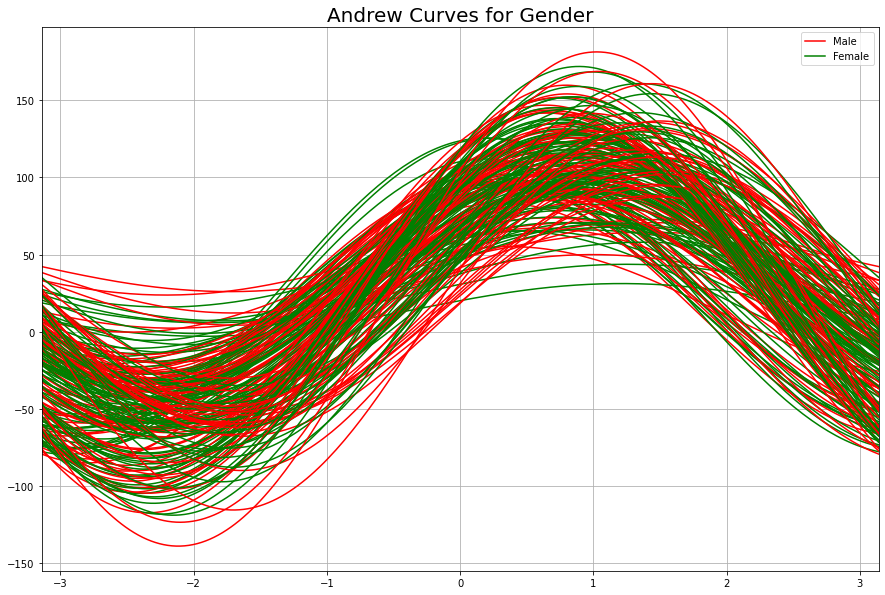

In [11]:
plt.rcParams['figure.figsize'] = (15, 10)


pd.plotting.andrews_curves(data.drop("CustomerID", axis=1), "Gender",color=["red","green"])
plt.title('Andrew Curves for Gender', fontsize = 20)
plt.show()

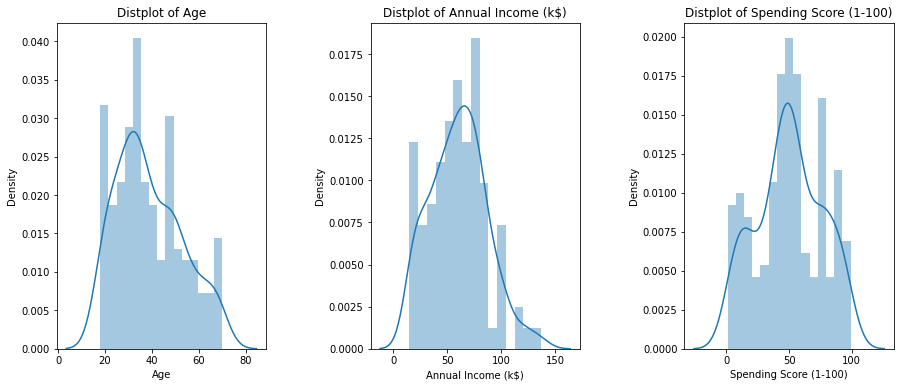

In [16]:

plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    sns.distplot(data[x] , bins = 15)
    plt.title('Distplot of {}'.format(x))
plt.show()

In [17]:
#Investigate different age groups for males and females
males_age = data[data['Gender']=='Male']['Age'] # subset with males age
females_age = data[data['Gender']=='Female']['Age'] # subset with females age

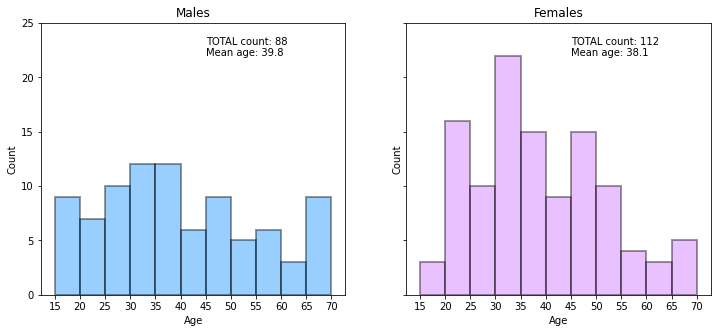

In [20]:
age_bins = range(15,75,5)

# males histogram
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)
sns.distplot(males_age, bins=age_bins, kde=False, color='#0089ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(age_bins)
ax1.set_ylim(top=25)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(45,23, "TOTAL count: {}".format(males_age.count()))
ax1.text(45,22, "Mean age: {:.1f}".format(males_age.mean()))

# females histogram
sns.distplot(females_age, bins=age_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(age_bins)
ax2.set_ylim(top=25)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(45,23, "TOTAL count: {}".format(females_age.count()))
ax2.text(45,22, "Mean age: {:.1f}".format(females_age.mean()))

plt.show()

The Boxen Plot shows a large number of quantiles.By plotting more quantiles, it provides more
information about the shape of the distribution, particularly in the tails.

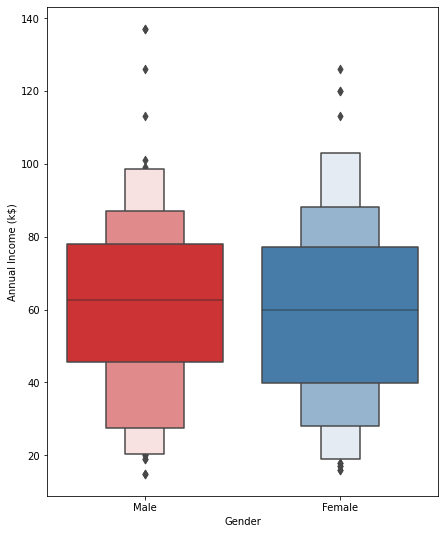

In [21]:
plt.figure(figsize=(7,9))
sns.boxenplot(x=data.Gender , y = data["Annual Income (k$)"] ,palette="Set1")
plt.show()

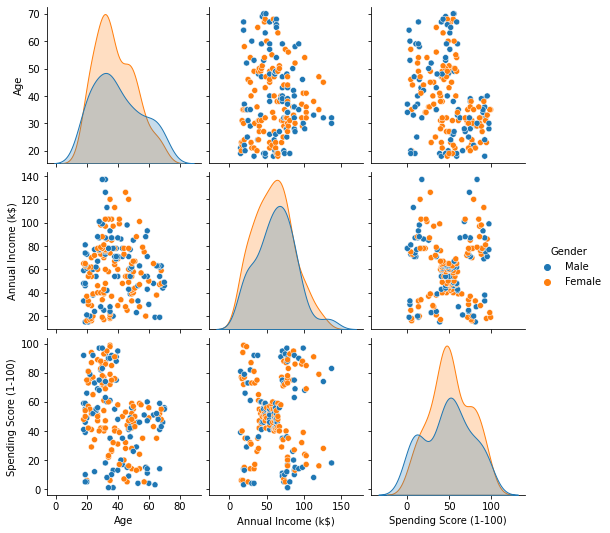

In [23]:
# Plot a subset of variables
sns.pairplot(data,hue = 'Gender',vars=['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)'])
plt.show()

## 1. Clustering with Kmeans

In [30]:

X = data[['Age' ,'Annual Income (k$)' ,'Spending Score (1-100)']]
inertia = []
s_scores = []
for n in range(2 , 11):
    algorithm = KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan').fit(X) 
    inertia.append(algorithm.inertia_)
    silhouette_avg = silhouette_score(X, algorithm.labels_)
    s_scores.append(silhouette_avg) # data for the silhouette score method

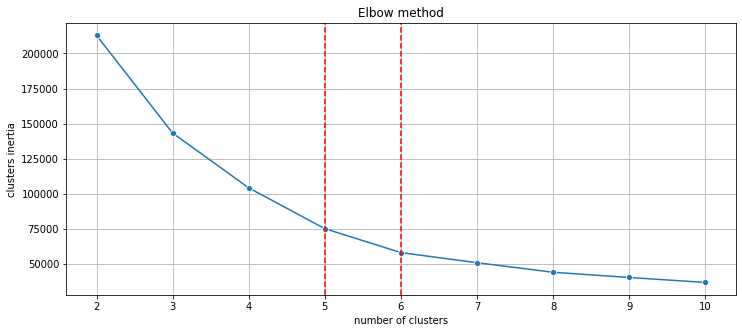

In [31]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(np.arange(2 , 11), inertia, marker='o', ax=ax)
ax.set_title("Elbow method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("clusters inertia")
ax.axvline(5, ls="--", c="red")
ax.axvline(6, ls="--", c="red")
plt.grid()
plt.show()

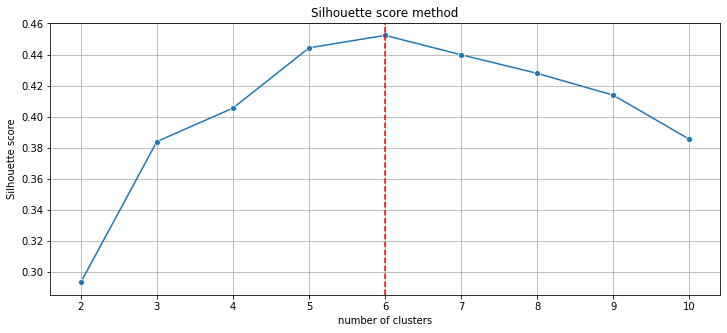

In [32]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(np.arange(2 , 11), s_scores, marker='o', ax=ax)
ax.set_title("Silhouette score method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("Silhouette score")
ax.axvline(6, ls="--", c="red")
plt.grid()
plt.show()

Silhouette score method/elbow method indicates the best options would be respectively 6 

In [33]:
KM6 = (KMeans(n_clusters = 6 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
KM6.fit(X)
labels6 = KM6.labels_
centroids6 = KM6.cluster_centers_
KM6_df = data.copy()
KM6_df['labels'] = labels6

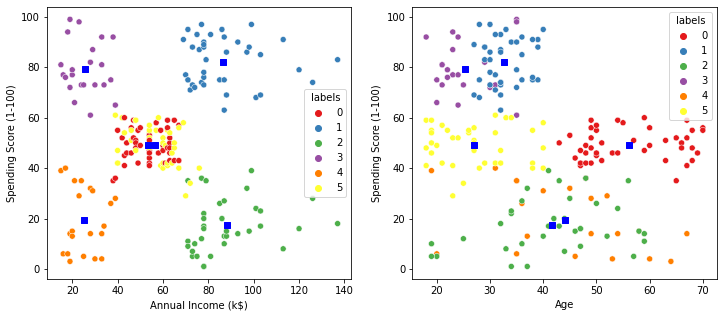

In [34]:

fig1, (axes) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)', data=KM6_df,
                hue='labels', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot('Age', 'Spending Score (1-100)', data=KM6_df,
                hue='labels', palette='Set1', ax=axes[1], legend='full')

axes[0].scatter(centroids6[:,1],centroids6[:,2], marker='s', s=40, c="blue")
axes[1].scatter(centroids6[:,0],centroids6[:,2], marker='s', s=40, c="blue")
plt.show()


K-Means algorithm generated the following 6 clusters:

- Older clients with medium annual income and medium spending score-0
- younger clients with high annual income and high  spending score-1
- Clients with high annual income and low spending score-2
- yonger clients with low annual income and high spending score-3
- clients with low annual income and low spending score-4
- younger clients with medium annual income and medium spending score-5

## 2. Clustering with Affinity Propogation Algorithm

Affinity Propagation
Do you remember high school, where groups of people formed – and you could only become a member of a particular group if the group’s leaders thought you were cool?

Affinity Propagation is a clustering algorithm proposed for the first time by Brendan Frey and Delbert Dueck in 2007 ("Clustering by Passing Messages Between Data Points") is somewhat based on this. It is built around the concept of sending messages between a pair of points until it converges. These messages are a way of measuring how similar these two points are to each other and can they be exemplars of each other. In plain english, for a set of data points, a “group formation” process begins, where each sample competes with other ones in order to gain group membership. The ones with most group capital, the group leaders are called exemplars

<b>The algorithm finds an optimum number of clusters itself contrary to kmeans where we have to specify the number of clusters.</b>
 This also implies very high time complexity cost of the order O(n²T) where n is the number of samples and T is the number of iterations until convergence. However, a big advantage of AP is the lack of sensitivity to the initialisation criteria.

The user is required to specify two parameters:

Preference which is a negative number and controls how many exemplars are used\
Damping factor which prevents numerical oscillations when updating messages
- Important points

    Contrary to K-means clustering, where convergence is determined with some threshold value, with Affinity Propagation you configure a number of iterations to complete\
    During each iteration, each sample broadcasts two types of messages to the other samples\

    - The first is called the responsibility r(i,k) – which is the “evidence that sample k should be the exemplar for sample i”.I always remember it as follows: the greater the expected group leadership of k, the greater the responsibility for the group.
    - The other type of message that is sent is the availability. This is the opposite of the responsibility: how certain i is that it should choose k as the exemplar, i.e. how available it is to join a particular group
    In the high school case, say that you want to join a semi-cool group (some availability), while you’re more willing to join the really cool group, your availability is much higher for the really cool one. The responsibility tells you something about whose acceptance you need to join the group, i.e. the most likely group leader i.e. exemplar.

In [36]:
no_of_clusters = []
preferences = range(-20000,-500,200)
af_sil_score = [] # silouette scores

for p in preferences:
    AF = AffinityPropagation(preference=p, max_iter=200).fit(X)
    no_of_clusters.append((len(np.unique(AF.labels_))))
    af_sil_score.append(silhouette_score(X, AF.labels_))
    
af_results = pd.DataFrame([preferences, no_of_clusters, af_sil_score], index=['preference','clusters', 'sil_score']).T
af_results.sort_values(by='sil_score', ascending=False).head()

,preference,clusters,sil_score
41,-11800.0,6.0,0.451649
14,-17200.0,6.0,0.451440
55,-9000.0,6.0,0.451440
26,-14800.0,6.0,0.451440
32,-13600.0,6.0,0.451440


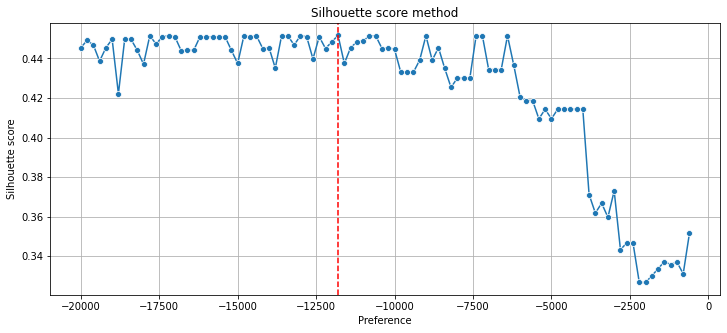

In [37]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(preferences, af_sil_score, marker='o', ax=ax)
ax.set_title("Silhouette score method")
ax.set_xlabel("Preference")
ax.set_ylabel("Silhouette score")
ax.axvline(-11800, ls="--", c="red")
plt.grid()
plt.show()

In [38]:
AF = AffinityPropagation(preference=-11800).fit(X)

In [39]:

AF_clustered = X.copy()
AF_clustered.loc[:,'Cluster'] = AF.labels_ # append labels to points

In [40]:
AF_clustered

,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,19,15,39,1
1,21,15,81,0
2,20,16,6,1
3,23,16,77,0
4,31,17,40,1
...,...,...,...,...
195,35,120,79,5
196,45,126,28,4
197,32,126,74,5
198,32,137,18,4


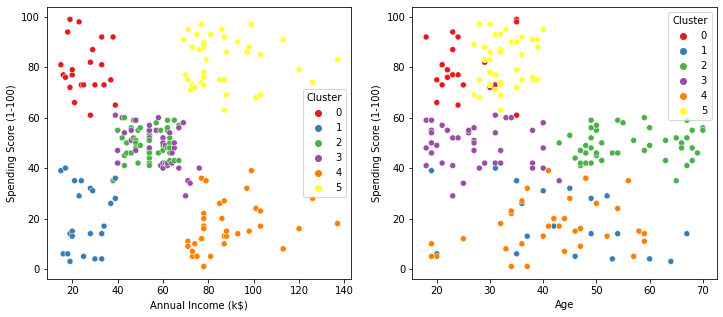

In [41]:
fig3, (ax_af) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)', data=AF_clustered,
                hue='Cluster', ax=ax_af[0], palette='Set1', legend='full')

sns.scatterplot('Age', 'Spending Score (1-100)', data=AF_clustered,
                hue='Cluster', palette='Set1', ax=ax_af[1], legend='full')

plt.setp(ax_af[0].get_legend().get_texts(), fontsize='10')
plt.setp(ax_af[1].get_legend().get_texts(), fontsize='10')
plt.show()

K-Means and Affinity Propagation algorithms created reasonable 6 clusters with similar meanings